In [1]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import LogisticRegression    # LR
from sklearn.svm import SVC                            # SVC
from sklearn.tree import DecisionTreeClassifier        # DT
from xgboost import XGBClassifier                      # XGB
from sklearn.multiclass import OneVsOneClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score  # Scoring functions
from sklearn.metrics import classification_report
from sklearn import metrics 

from sklearn.model_selection import GridSearchCV, StratifiedKFold

import time
from prettytable import PrettyTable
from tabulate import tabulate

In [2]:
path = '/Users/tristangarcia/desktop/Network Traffic Classification/data/final/'

# Loading files
x_train = pd.read_pickle(f'{path}pcatrain.pkl')
y_train = pd.read_pickle(f'{path}ytrain.pkl')
y2_train = pd.read_pickle(f'{path}y2train.pkl')


x_test = pd.read_pickle(f'{path}pcavalidate.pkl')
y_test = pd.read_pickle(f'{path}yvalidate.pkl')
y2_test = pd.read_pickle(f'{path}y2validate.pkl')

In [3]:
# Using Stage 1's best model
model = XGBClassifier(max_depth=32, min_child_weight=1,
                      colsample_bytree=1, subsample=1, 
                      n_estimators=100)

model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [4]:
# Predict on the test set for Stage 1
y_pred = model.predict(x_test)

# Evaluate the model
print("Stage 1 - Binary Classification Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Stage 1 - Binary Classification Results:
Accuracy: 0.99112215371097
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     52673
           1       0.98      0.98      0.98     13334

    accuracy                           0.99     66007
   macro avg       0.99      0.99      0.99     66007
weighted avg       0.99      0.99      0.99     66007



In [5]:
y2_test = y2_test.reset_index(drop=True)      # Reset index as it was causing errors before

# Get indices for test predictions (attack label == 1)
attack_indices_test = [i for i, pred in enumerate(y_pred) if pred == 1]

# Filter Stage 2 data for the rows predicted as attacks
x_test = x_test.iloc[attack_indices_test]
y2_test = y2_test.iloc[attack_indices_test]

In [6]:
y2_train = y2_train.squeeze()
y2_test = y2_test.squeeze()

In [7]:
y2_test.value_counts()

y2_test
5    9272
3    1668
2     729
4     627
7     512
6     298
1      98
0      87
8      47
9       6
Name: count, dtype: int64

# Helper Functions

In [8]:
labels = ['analysis', 'backdoor', 'dos', 'exploits', 'fuzzers', 'generic', 
          'normal', 'reconnaissance', 'shellcode', 'worms']

In [9]:
results = {'model':[], 'accuracy':[], 'f1':[], 'far':[]}

def add_model_results(model_name, accuracy, f1, far):
    results['model'].append(model_name)
    results['accuracy'].append(accuracy)
    results['f1'].append(f1)
    results['far'].append(far)

In [10]:
def false_alarm_rate(y_true, y_pred):
    """
    Calculate False Positive Rate (FPR) and False Negative Rate (FNR) for multiclass.
    """
    cm = confusion_matrix(y_true, y_pred)
    tp = np.diag(cm)    # True positives
    fp = cm.sum(axis=0) - tp    # False positives
    fn = cm.sum(axis=1) - tp    # False negatives
    tn = cm.sum() - (fp + fn + tp)    # True negatives

    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    # Avoid division by zero and invalid values
    fpr = np.nan_to_num(fpr)  # Replace NaNs with 0
    fnr = np.nan_to_num(fnr)  # Replace NaNs with 0
    
    FAR = np.round(np.mean((fpr/fnr) / 2), 4)
    return FAR

    
def plot_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred, labels):
    """
    Plot confusion matrices for both train and test datasets.
    """
    train_cmap=sns.light_palette("green")
    test_cmap=sns.light_palette("blue")
    
    plt.figure(figsize=(16,5))
    
    # Train confusion matrix
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, cmap=train_cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")
    
    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, cmap=test_cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    
    plt.show()

In [11]:
def evaluate_model(model, x_train, y_train, x_test, y_test, model_name, labels=labels):
    """ 
    Evaluate model performance on train and test data, using smaller helper functions.
    """
    # Train the model
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # Calculate metrics for train set
    train_accuracy = round(accuracy_score(y_train, y_train_pred), 4)
    train_f1 = round(f1_score(y_train, y_train_pred, average='macro', zero_division=0), 4)
    train_far = round(false_alarm_rate(y_train, y_train_pred), 4)
    # Calculate metrics for test set
    test_accuracy = round(accuracy_score(y_test, y_test_pred), 4)
    test_f1 = round(f1_score(y_test, y_test_pred, average='macro', zero_division=0), 4)
    test_far = round(false_alarm_rate(y_test, y_test_pred), 4)

    # Print classification reports
    print(f"Model: {model_name}")
    print('Train Set')
    print(classification_report(y_train, y_train_pred, target_names=labels, digits=4, zero_division=0))
    print("\nTest Set")
    print(classification_report(y_test, y_test_pred, target_names=labels, digits=4, zero_division=0))
    
    # Plot confusion matrices
    plot_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred, labels)
    
    # Appending to results table
    add_model_results(model_name, test_accuracy, test_f1, test_far)

# Logistic Regression

Model: LR(l1)
Train Set
                precision    recall  f1-score   support

      analysis     0.0000    0.0000    0.0000       469
      backdoor     0.0000    0.0000    0.0000       466
           dos     0.3727    0.3269    0.3483      3435
      exploits     0.4875    0.4320    0.4581      8007
       fuzzers     0.3661    0.2521    0.2985      3773
       generic     0.9961    0.9770    0.9865     43315
        normal     0.9729    0.9912    0.9819    245804
reconnaissance     0.3639    0.3513    0.3575      2471
     shellcode     0.0000    0.0000    0.0000       260
         worms     0.5000    0.0667    0.1176        30

      accuracy                         0.9491    308030
     macro avg     0.4059    0.3397    0.3548    308030
  weighted avg     0.9407    0.9491    0.9446    308030


Test Set
                precision    recall  f1-score   support

      analysis     0.0000    0.0000    0.0000        87
      backdoor     0.0000    0.0000    0.0000        98
          

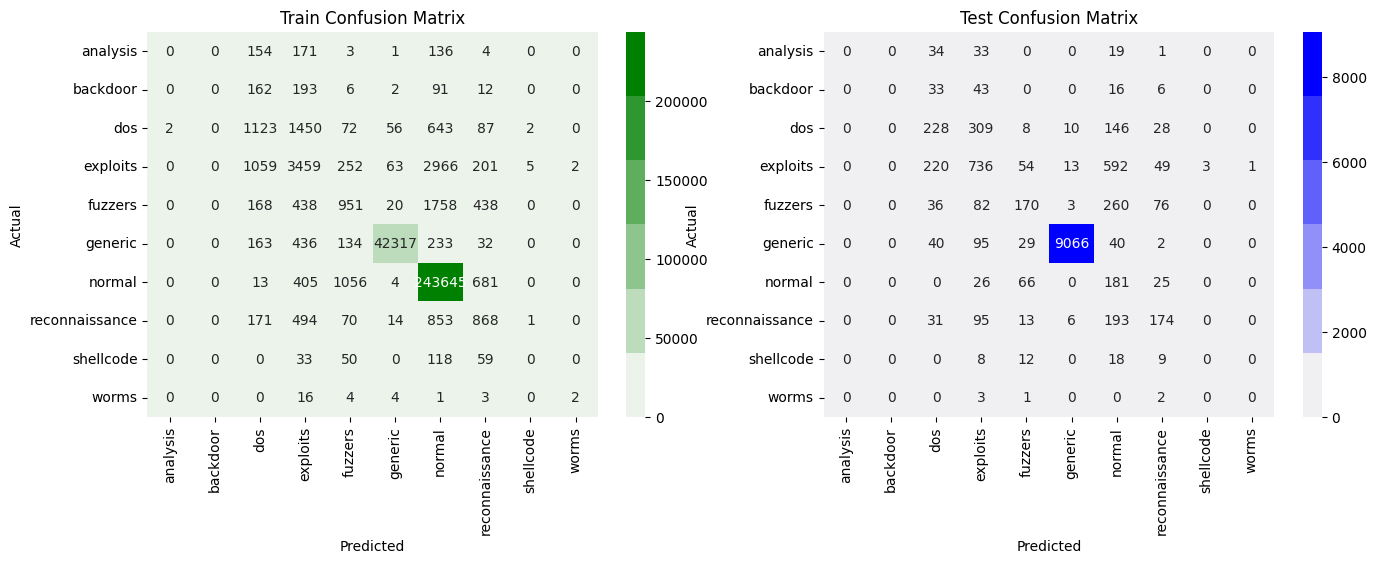

In [12]:
lr1 = OneVsOneClassifier(LogisticRegression(penalty='l1',solver='liblinear', max_iter=10000))
evaluate_model(lr1, x_train, y2_train, x_test, y2_test, 'LR(l1)')

In [13]:
results

{'model': ['LR(l1)'], 'accuracy': [0.791], 'f1': [0.2746], 'far': [0.04]}

Model: LR(l2)
Train Set
                precision    recall  f1-score   support

      analysis     0.0000    0.0000    0.0000       469
      backdoor     0.0000    0.0000    0.0000       466
           dos     0.3773    0.3450    0.3604      3435
      exploits     0.4842    0.4375    0.4597      8007
       fuzzers     0.3647    0.2616    0.3047      3773
       generic     0.9963    0.9769    0.9865     43315
        normal     0.9741    0.9910    0.9825    245804
reconnaissance     0.3572    0.3488    0.3530      2471
     shellcode     0.0000    0.0000    0.0000       260
         worms     0.0000    0.0000    0.0000        30

      accuracy                         0.9494    308030
     macro avg     0.3554    0.3361    0.3447    308030
  weighted avg     0.9415    0.9494    0.9452    308030


Test Set
                precision    recall  f1-score   support

      analysis     0.0000    0.0000    0.0000        87
      backdoor     0.0000    0.0000    0.0000        98
          

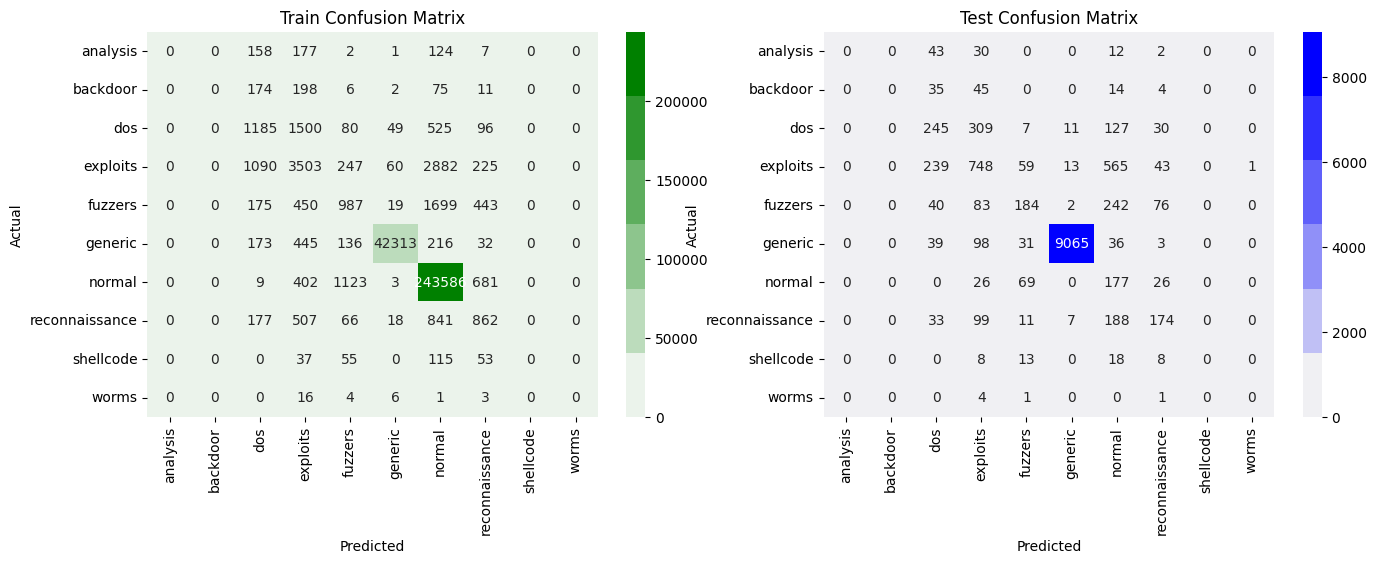

In [14]:
lr2 = OneVsOneClassifier(LogisticRegression(penalty='l2',solver='lbfgs', max_iter=10000))
evaluate_model(lr2, x_train, y2_train, x_test, y2_test, 'LR(l2)')

In [15]:
results

{'model': ['LR(l1)', 'LR(l2)'],
 'accuracy': [0.791, 0.7938],
 'f1': [0.2746, 0.279],
 'far': [0.04, 0.0397]}

# Support Vector Classifier

Model: SVC
Train Set
                precision    recall  f1-score   support

      analysis     0.0000    0.0000    0.0000       469
      backdoor     0.0000    0.0000    0.0000       466
           dos     0.3896    0.3799    0.3847      3435
      exploits     0.5984    0.7505    0.6659      8007
       fuzzers     0.5207    0.1831    0.2710      3773
       generic     0.9987    0.9761    0.9872     43315
        normal     0.9841    0.9964    0.9902    245804
reconnaissance     0.5630    0.4735    0.5144      2471
     shellcode     0.0000    0.0000    0.0000       260
         worms     0.0000    0.0000    0.0000        30

      accuracy                         0.9622    308030
     macro avg     0.4054    0.3760    0.3813    308030
  weighted avg     0.9565    0.9622    0.9580    308030


Test Set
                precision    recall  f1-score   support

      analysis     0.0000    0.0000    0.0000        87
      backdoor     0.0000    0.0000    0.0000        98
           do

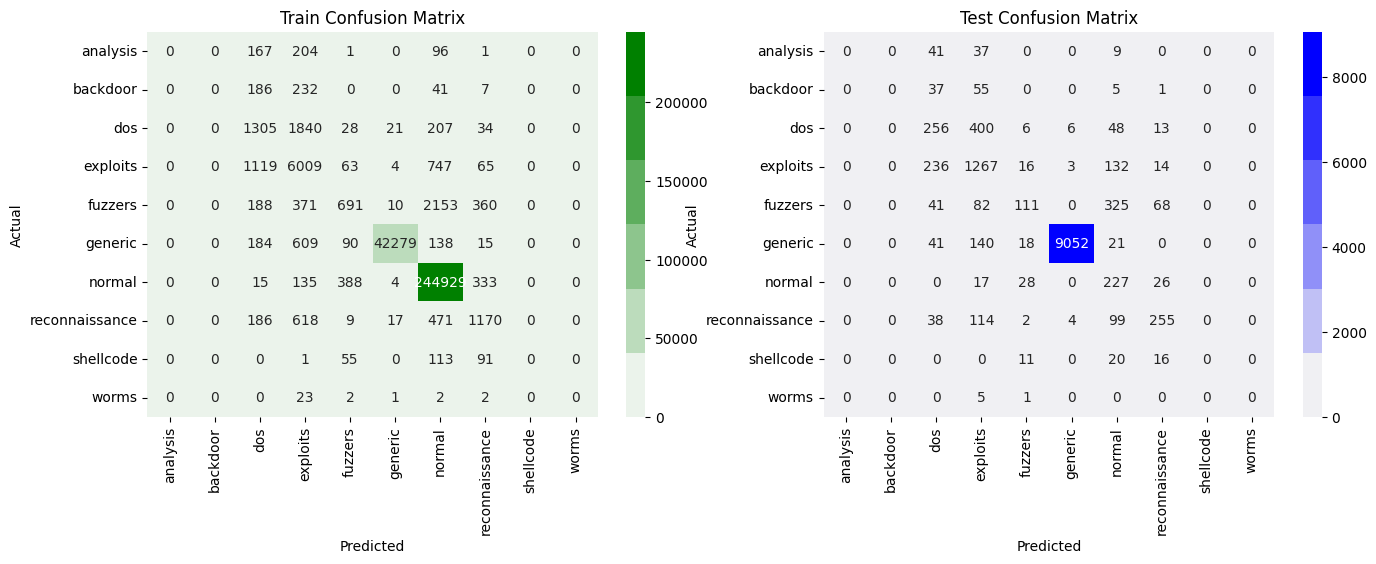

In [16]:
svc = OneVsOneClassifier(SVC())
evaluate_model(svc, x_train, y2_train, x_test, y2_test, 'SVC')

In [17]:
results

{'model': ['LR(l1)', 'LR(l2)', 'SVC'],
 'accuracy': [0.791, 0.7938, 0.8369],
 'f1': [0.2746, 0.279, 0.3235],
 'far': [0.04, 0.0397, 0.0366]}

# Decision Tree

/var/folders/vr/skwvh_8x0gzcmpxx950wbv9c0000gn/T/ipykernel_1852/1062622417.py:17: RuntimeWarning: invalid value encountered in divide
  FAR = np.round(np.mean((fpr/fnr) / 2), 4)


Model: DT
Train Set
                precision    recall  f1-score   support

      analysis     0.9903    0.2175    0.3566       469
      backdoor     0.9265    0.1352    0.2360       466
           dos     0.4915    0.6422    0.5569      3435
      exploits     0.7489    0.8444    0.7938      8007
       fuzzers     0.9955    0.8884    0.9389      3773
       generic     1.0000    0.9896    0.9948     43315
        normal     1.0000    1.0000    1.0000    245804
reconnaissance     1.0000    0.8191    0.9006      2471
     shellcode     1.0000    1.0000    1.0000       260
         worms     1.0000    0.8667    0.9286        30

      accuracy                         0.9851    308030
     macro avg     0.9153    0.7403    0.7706    308030
  weighted avg     0.9876    0.9851    0.9853    308030


Test Set
                precision    recall  f1-score   support

      analysis     0.8333    0.0575    0.1075        87
      backdoor     0.0000    0.0000    0.0000        98
           dos

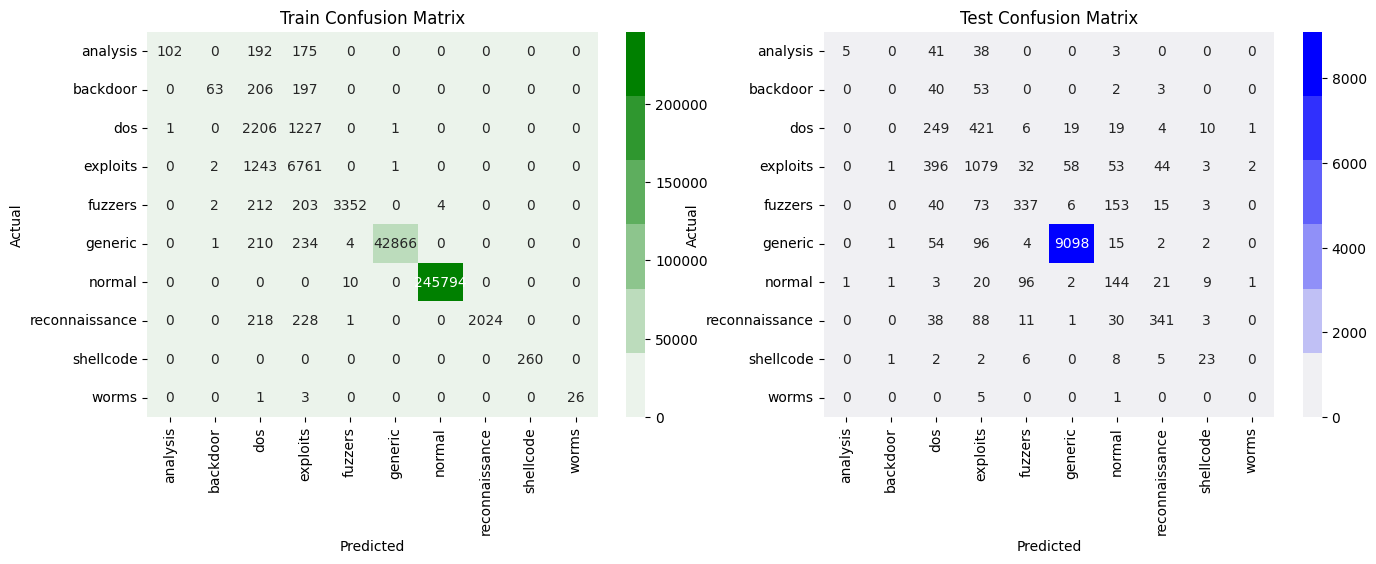

In [18]:
dt = OneVsOneClassifier(DecisionTreeClassifier())
evaluate_model(dt, x_train, y2_train, x_test, y2_test, 'DT')

In [19]:
results

{'model': ['LR(l1)', 'LR(l2)', 'SVC', 'DT'],
 'accuracy': [0.791, 0.7938, 0.8369, 0.845],
 'f1': [0.2746, 0.279, 0.3235, 0.4195],
 'far': [0.04, 0.0397, 0.0366, 0.0744]}

# XGBoost

/var/folders/vr/skwvh_8x0gzcmpxx950wbv9c0000gn/T/ipykernel_1852/1062622417.py:17: RuntimeWarning: divide by zero encountered in divide
  FAR = np.round(np.mean((fpr/fnr) / 2), 4)


Model: XGB
Train Set
                precision    recall  f1-score   support

      analysis     0.9903    0.2175    0.3566       469
      backdoor     0.9839    0.1309    0.2311       466
           dos     0.5047    0.5470    0.5250      3435
      exploits     0.7154    0.8694    0.7849      8007
       fuzzers     0.9414    0.8049    0.8678      3773
       generic     0.9995    0.9896    0.9945     43315
        normal     0.9986    0.9992    0.9989    245804
reconnaissance     0.9936    0.8199    0.8984      2471
     shellcode     0.9848    1.0000    0.9924       260
         worms     1.0000    0.8667    0.9286        30

      accuracy                         0.9831    308030
     macro avg     0.9112    0.7245    0.7578    308030
  weighted avg     0.9850    0.9831    0.9829    308030


Test Set
                precision    recall  f1-score   support

      analysis     1.0000    0.0805    0.1489        87
      backdoor     0.0000    0.0000    0.0000        98
           do

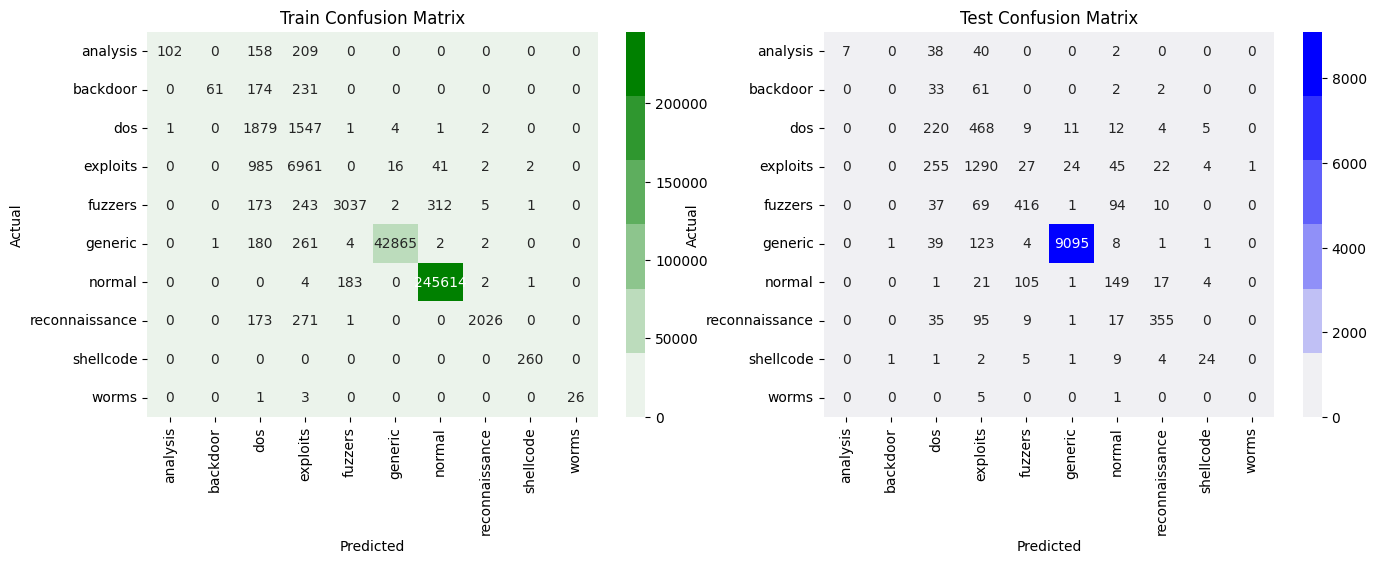

In [20]:
xgb = OneVsOneClassifier(XGBClassifier())
evaluate_model(xgb, x_train, y2_train, x_test, y2_test, 'XGB')

In [21]:
results

{'model': ['LR(l1)', 'LR(l2)', 'SVC', 'DT', 'XGB'],
 'accuracy': [0.791, 0.7938, 0.8369, 0.845, 0.866],
 'f1': [0.2746, 0.279, 0.3235, 0.4195, 0.4616],
 'far': [0.04, 0.0397, 0.0366, 0.0744, 0.0485]}

# Results Tables

In [22]:
results = pd.DataFrame(results)
print(tabulate(results, headers='keys'))

    model      accuracy      f1     far
--  -------  ----------  ------  ------
 0  LR(l1)       0.791   0.2746  0.04
 1  LR(l2)       0.7938  0.279   0.0397
 2  SVC          0.8369  0.3235  0.0366
 3  DT           0.845   0.4195  0.0744
 4  XGB          0.866   0.4616  0.0485
